### Dodatkowe kody

Heatmapa:

In [48]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img


Biblioteki (failsafe):

In [49]:
#Narzędzia:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

#Klasyfikatory + Ewaluacja

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

#Preprocessing:

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from bs4 import BeautifulSoup
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Selekcja Cech:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

#Dodatkowa Wizualizacja:

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

# Określanie Osobowości z tekstu

    Skala MBTI to skala osobowości rozwinieta przez Myersa-Briggsa w celu oepracjonalizacji klasycznych cech osobowości
    by były one bardziej deskryptywne i umożliwiały predykcję zachowań. Skala MBTI opiera się na 4 wymiarach binarnych:
    
        Introwersja (I)- Ekstrawersja (E):
        
            preferencje co do skupiania sie na świecie Wewnętrznym i Zewnętrznym
            
        Intuition (N) - Sensing (S):
        
           Zwracanie uwagi na znaczenie, interpetację, szukanie dodatkowych wyjaśnień vs. 
           Skupianie się na podstawowych informacjach ostarczonych przez zmysły i przydatnych dla mnie
            
        Thinking (T) - Feeling (F):
        
            Podejmowanie Decyzji za pomocą głebokiej Analizy, rozumowania, wiedzy oraz logiki vs.
            podejmowanie decyzji za pomocą własnych intuicji
            
        Judging (J) - Perceiving (P):
        
            W kontaktach ze światem zewnetrznym szybkie i skuteczne podejmowanie decyzji vs.
            otwarcie na nowe doświadczenia i luźny stosunek do pracy
            
        Każdy z tych wymiarów może byc traktowany niezaleznie i nieemergentnie prowadzi do 16 Typów osobowości MBTI.
        
        ['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP']
       
       Kazdy z tych typów ma swoje własności, ale są one do przewidzenia na podstawie wartosci indywidualnych wymiarów
       
        

### Wczytanie danych, Ekstrakcja Cech oraz Wizualizacja

**Proszę pamiętać, że ścieżka nie jest doprecyzowana i wymaga przeniesienia pliku mbti_1.csv z repozytorium do niechronionej lokalizacji**

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#PROSZĘ DOPRECYZOWAĆ ŚCIEŻKĘ!!! jako tą w której umieszczono plik!
#preferowanie downloads. Proszę doprecyzować użytkownika

df = pd.read_csv(r"C:\Users\Michał\Downloads\mbti_1.csv",sep = ",", engine = "python")
df


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


Wizualizacja udziału klas: Podejrzenie znaczącego efektu niebalansowania

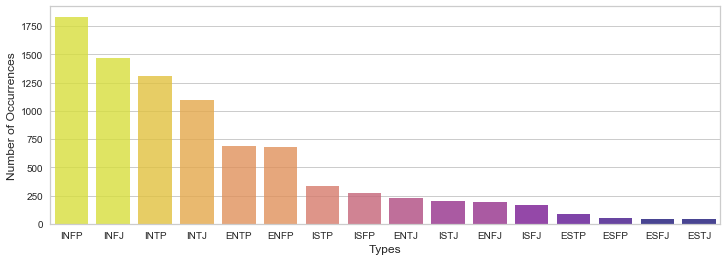

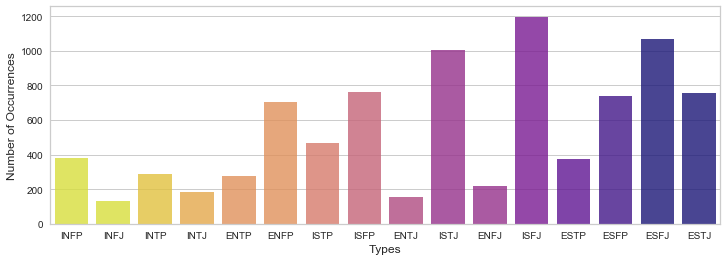

In [63]:

#Wizualizacja udziału Klas

from matplotlib import cm

cnt_srs = df['type'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

#Wizualizacja udziału Klas w Społeczeństwie

from matplotlib import cm
Procentowy = [len(df)*0.044,len(df)*0.015,len(df)*0.033,len(df)*0.021,len(df)*0.032,len(df)*0.081,len(df)*0.054,len(df)*0.088,len(df)*0.018,len(df)*0.116,len(df)*0.025,len(df)*0.138,len(df)*0.043,len(df)*0.085,len(df)*0.123,len(df)*0.087]
cnt_srs = df['type'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, Procentowy, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

Nasze dane **nie**  odpowiadają rozkładowi w społeczeństwie

     Z powodu antagonizacji wymiarów binarnych, możemy sie spodziewać, ze coś co może róznicować osoby o różnych Cechach to ilość użytcych słów. Następnym takim czynnikiem może być również ilosć użytych linków (chęć dzielenia sie informacją), mówienie o abstrakcji i personalnych doświadczeniach (muzyka), niepewnosć (np. poprzez ilosć wielokropków), oraz udostępniane obrazki.
     
     Taką cechą może być również mówienie o sobie (użycie 'I')

Z naszych postów ekstraktujemy wybrane Cechy: ilosc słow na osobę, ilość wielokropków, ilośc linków, ilość muzyki, ilość jpgów, ilość użycia 'I'

In [64]:
def words_per_post():

    df['words_per_post'] = 0
    for i in range(len(df.index)):
        df['words_per_post'].loc[i] = len(df["posts"].loc[i].split())/50
        #print(len(df["posts"].loc[i].split())/50)

def Average_frase_per_person(frase):
    df["{} per Post".format(frase)] = 0
    for i in range(len(df.index)):
        df["{} per Post".format(frase)].loc[i]  = df["posts"].loc[i].count(frase)/50
   
    
    


#### Ekstrakcja

In [65]:
#Cecha 1: Ile słów na post używa dana osoba?

words_per_post()
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92
8671,ENFP,'So...if this thread already exists someplace ...,26.18
8672,INTP,'So many questions when i do these things. I ...,18.96
8673,INFP,'I am very conflicted right now when it comes ...,34.10


In [66]:
#Cecha 2: Ile średnio wielokropków na post używa dana osoba?

Average_frase_per_person('...')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42
...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94


In [67]:

#Cecha 3: Ile średnio linków na post używa dana osoba?
Average_frase_per_person('http')
df


C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12
...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00


In [68]:
#Cecha 4: Ile średnio frazy 'Muzyka' na post używa dana osoba?

Average_frase_per_person('music')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post,music per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14,0.00
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04,0.00
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04,0.00
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00,0.00


In [69]:
#Cecha 5: Ile średnio obrazków na post używa dana osoba?

Average_frase_per_person('jpg')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post,music per Post,jpg per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02,0.12
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00,0.02
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00,0.00
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02,0.00
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02,0.04
...,...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14,0.00,0.02
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04,0.00,0.00
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04,0.00,0.00
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00,0.00,0.00


In [70]:
#Cecha 6: Ile średnio SŁowa 'I' na post używa dana osoba?
#Wzięte z Analizy częstości występowania

Average_frase_per_person('I')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post,music per Post,jpg per Post,I per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02,0.12,0.46
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00,0.02,2.02
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00,0.00,0.98
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02,0.00,1.74
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02,0.04,0.92
...,...,...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14,0.00,0.02,1.02
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04,0.00,0.00,2.40
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04,0.00,0.00,0.98
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00,0.00,0.00,3.22


#### Wizualizacja

Zobaczmy na ile wybrane Cechy różnią się pomiędzy grupami. Zwizualizujmy je razem, gdzie podobienstwo bedzie widoczne komparatytywnie

In [71]:
#Wizualizacja Razem --> pokazanie że średnie są niemalże identyczne ==> słaba rozpoznawalność

def wykres_osobowosci_razem(od_czego,do_czego='type'):
    from matplotlib import cm
  
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 16))

    typ_osobow = np.unique(df[do_czego])
    plt.figure(figsize = (10,10))
   # cmap = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(typ_osobow)):
        plt.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[i])
        plt.hist(df[od_czego].loc[df[do_czego]==typ_osobow[i]],bins=25,color=colors[i])
        plt.title(od_czego)
        plt.xlabel(" per post")
        plt.ylabel("Number of records")

        #print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df['type']==typ_osobow[i]])))
    plt.legend(typ_osobow)
    plt.show

#wizualizacja poszczególnych Cech dla wybranych typów osobowości

def wykres_osobowosci(od_czego,ticks=(0,5,10,15,20,25,30,35),tyks=[0,100,200,300,400,500,600,700,800]):
    from matplotlib import cm
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 16))
    
    typ_osobow = np.unique(df['type'])
    fig,axes = plt.subplots(4,4,figsize=(20,20))
    for i,ax in zip(range(len(typ_osobow)),axes.ravel()):
        ax.hist(df[od_czego].loc[df['type']==typ_osobow[i]],bins=25,color=colors[12])
        ax.axvline(x=np.mean(df[od_czego].loc[df['type']==typ_osobow[i]]),color=colors[4])
        ax.set_xticks(ticks)
        ax.set_xlabel("per post")
        ax.set_ylabel("Number of records")
        ax.set_yticks(tyks)
        ax.title.set_text(typ_osobow[i])
        print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df['type']==typ_osobow[i]])))
    plt.show

    



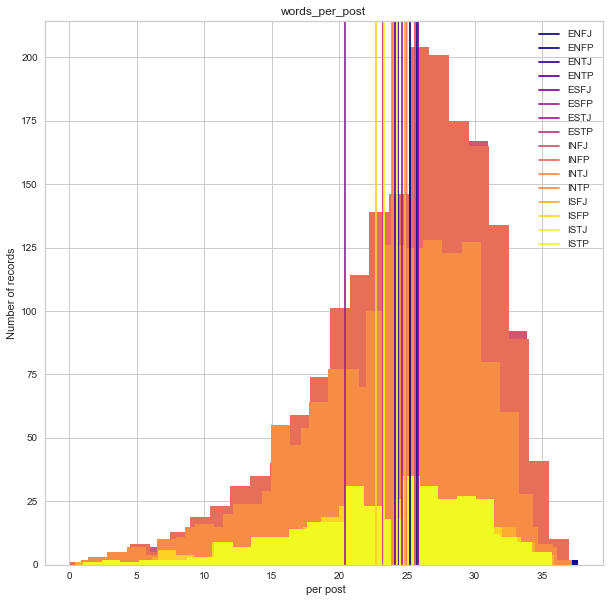

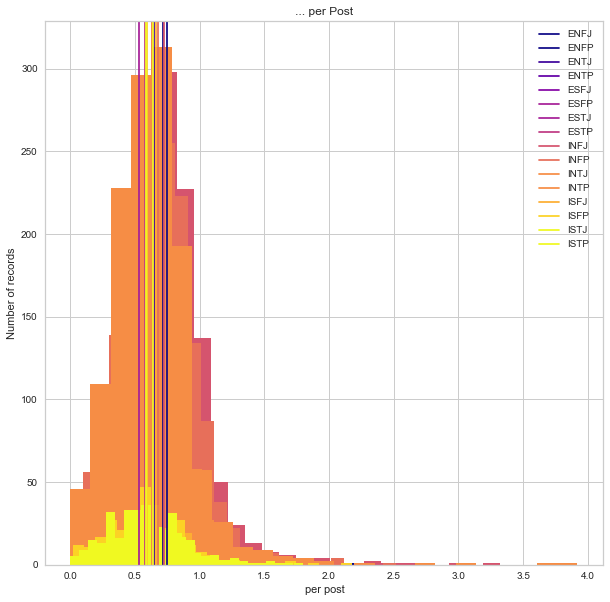

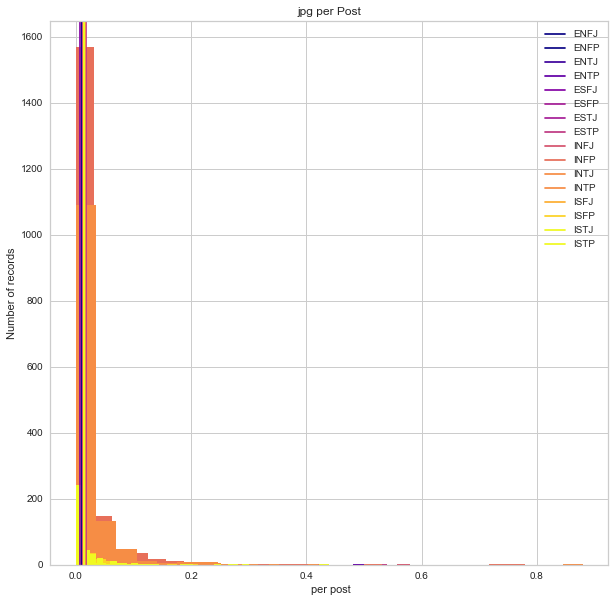

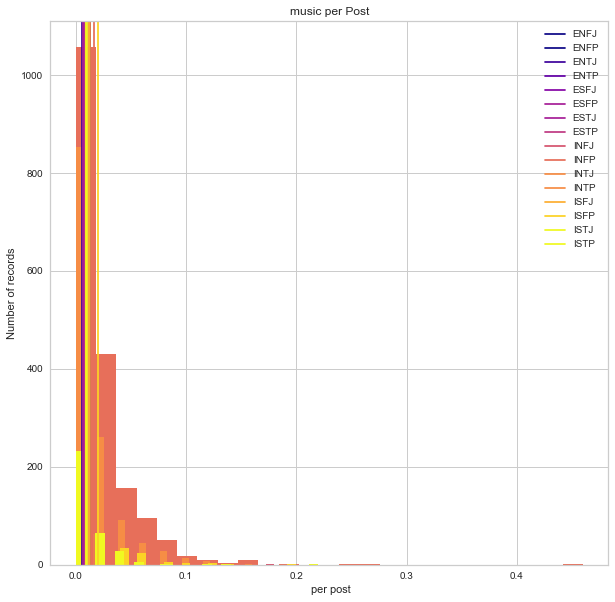

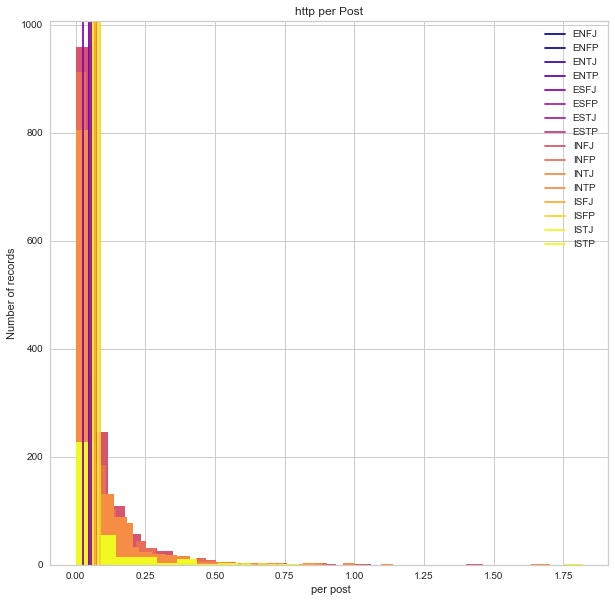

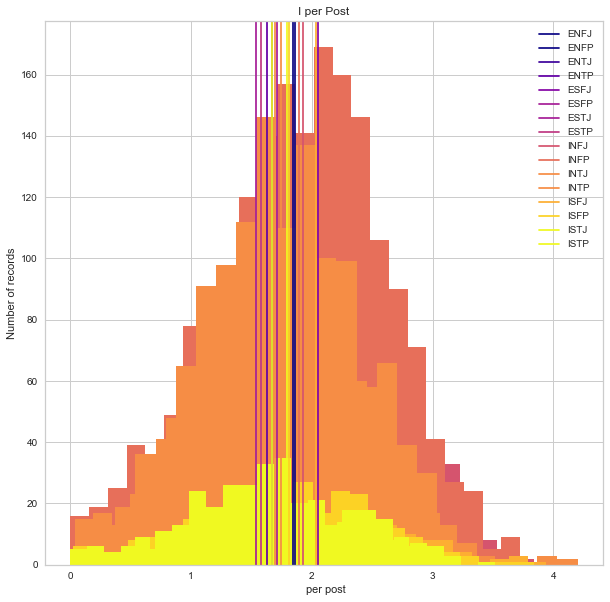

In [72]:
wykres_osobowosci_razem('words_per_post')
wykres_osobowosci_razem('... per Post')
wykres_osobowosci_razem('jpg per Post')
wykres_osobowosci_razem('music per Post')
wykres_osobowosci_razem('http per Post')
wykres_osobowosci_razem('I per Post')

z faktu, że większosc danych sie pokrywa, możemy wnioskowac podobną strukturę. Średnie również nie rożnią się znacząco pomiędzy typami osobowości

Pokażemy osobno każdą Cechę ,żeby to potwierdzić oraz pokażemy średnie

ENFJ: 25.731789473684206
ENFP: 25.21558518518521
ENTJ: 24.361991341991345
ENTP: 24.12002919708029
ESFJ: 25.81
ESFP: 20.4425
ESTJ: 24.59076923076923
ESTP: 23.25191011235956
INFJ: 25.56888435374151
INFP: 24.891266375545865
INTJ: 23.891732355637053
INTP: 23.95547546012269
ISFJ: 24.82590361445782
ISFP: 22.728265682656826
ISTJ: 24.264487804878044
ISTP: 23.3113353115727


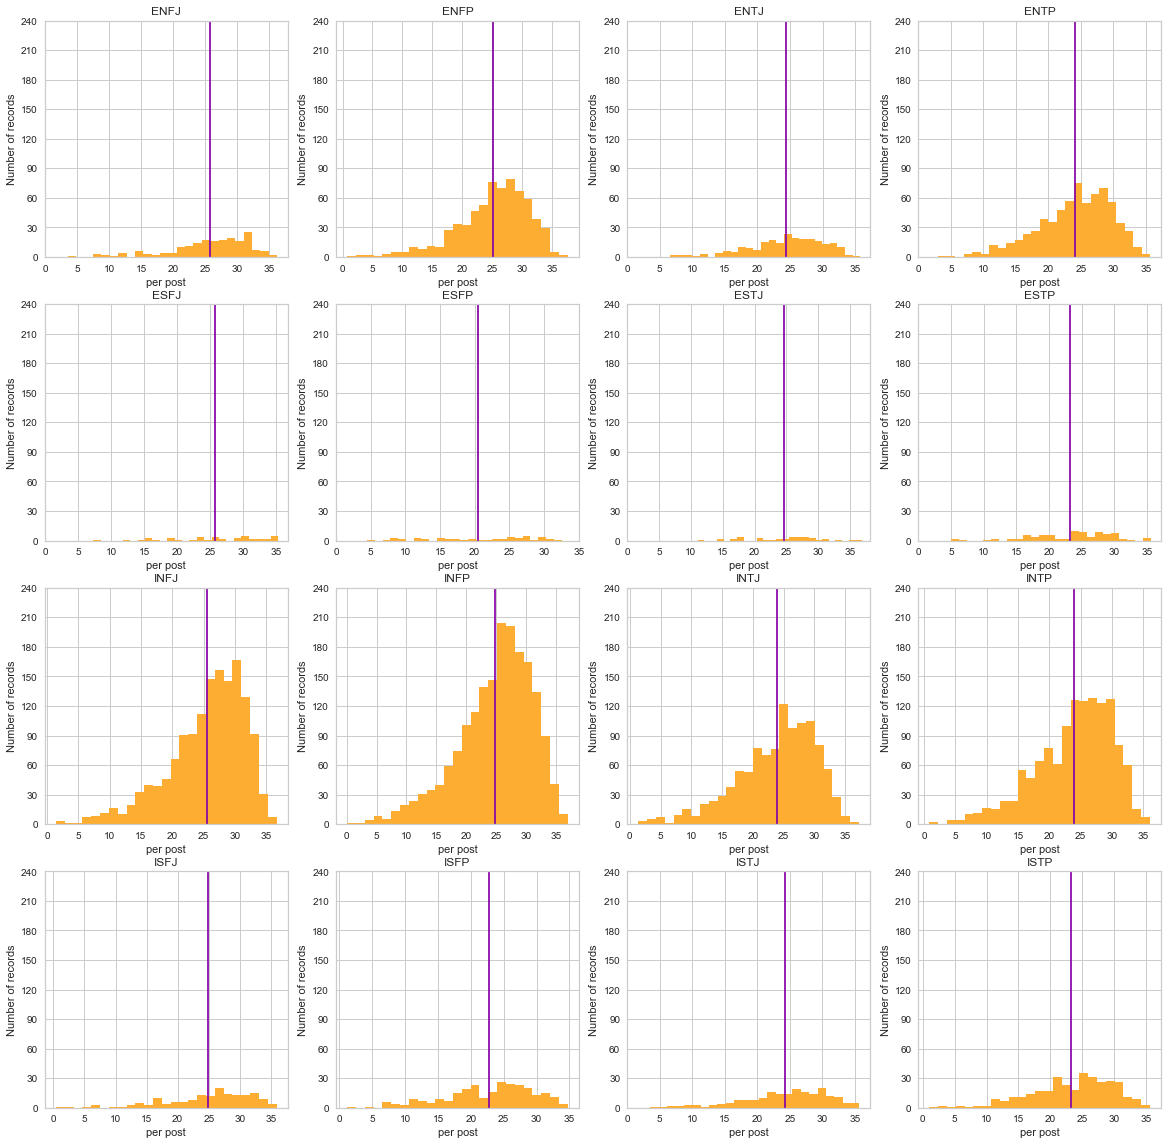

In [73]:
#Ilość słów na post

wykres_osobowosci('words_per_post',tyks=[0,30,60,90,120,150,180,210,240]
)

ENFJ: 0.05326315789473676
ENFP: 0.05045925925925915
ENTJ: 0.05316017316017309
ENTP: 0.048262773722627564
ESFJ: 0.027142857142857146
ESFP: 0.05541666666666667
ESTJ: 0.05282051282051283
ESTP: 0.06471910112359547
INFJ: 0.06587755102040828
INFP: 0.07542576419213985
INTJ: 0.06359303391384065
INTP: 0.07076687116564434
ISFJ: 0.07060240963855414
ISFP: 0.08833948339483383
ISTJ: 0.06117073170731704
ISTP: 0.08100890207715115


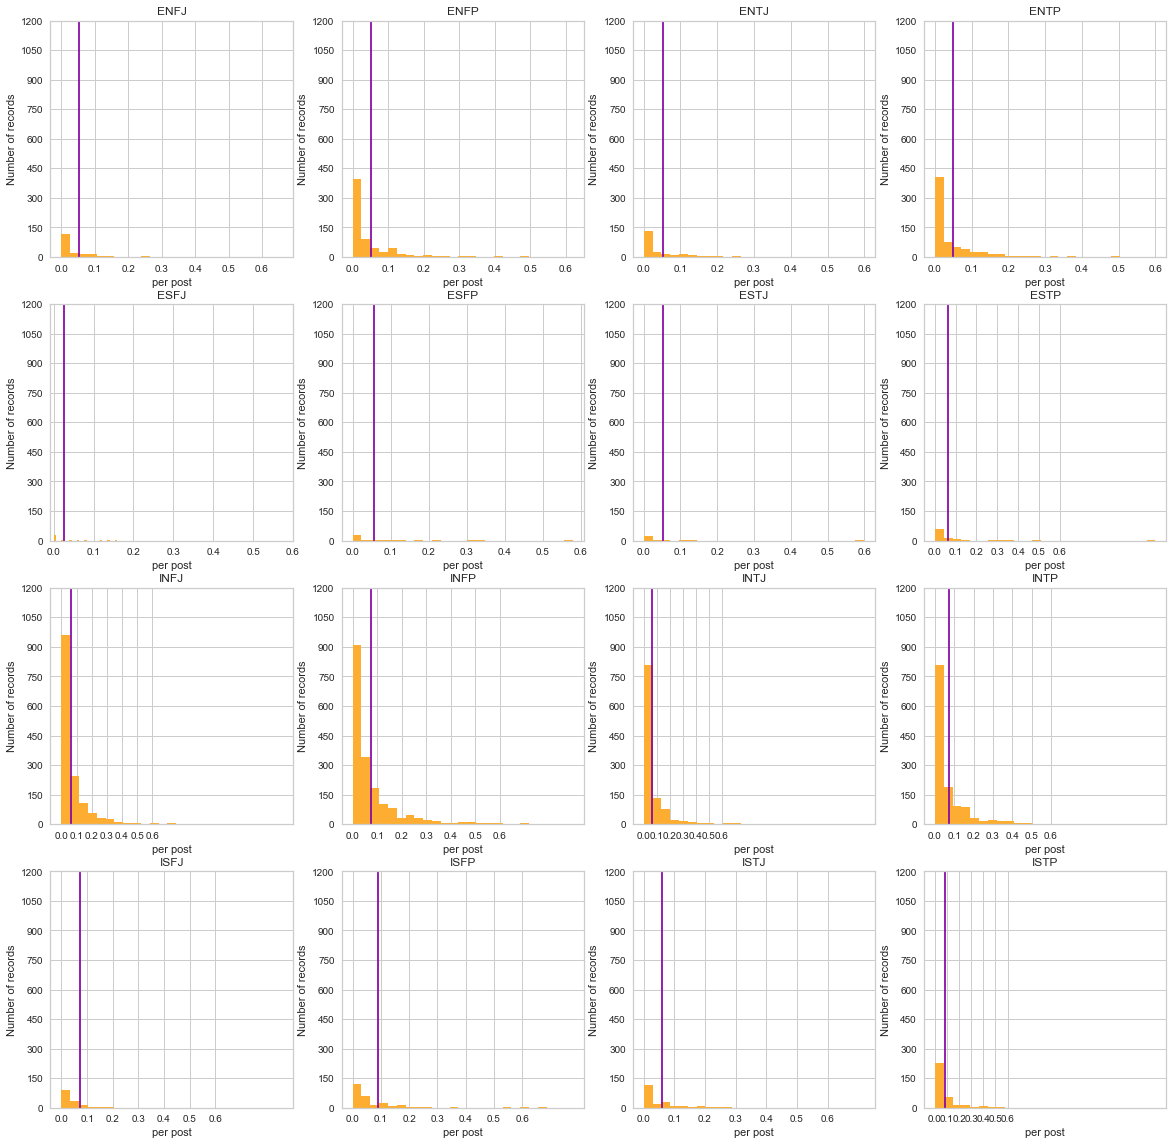

In [74]:
#ilość linków

wykres_osobowosci('http per Post',ticks=(0.0,0.1,0.2,0.3,0.4,0.5,0.6),tyks=[0,150,300,450,600,750,900,1050,1200])


ENFJ: 0.7444210526315788
ENFP: 0.7158814814814816
ENTJ: 0.646666666666667
ENTP: 0.6310364963503654
ESFJ: 0.6385714285714285
ESFP: 0.53375
ESTJ: 0.6307692307692309
ESTP: 0.5775280898876403
INFJ: 0.7214285714285714
INFP: 0.6765938864628811
INTJ: 0.6305407882676447
INTP: 0.6321779141104287
ISFJ: 0.66144578313253
ISFP: 0.5961623616236162
ISTJ: 0.6383414634146342
ISTP: 0.5869436201780414


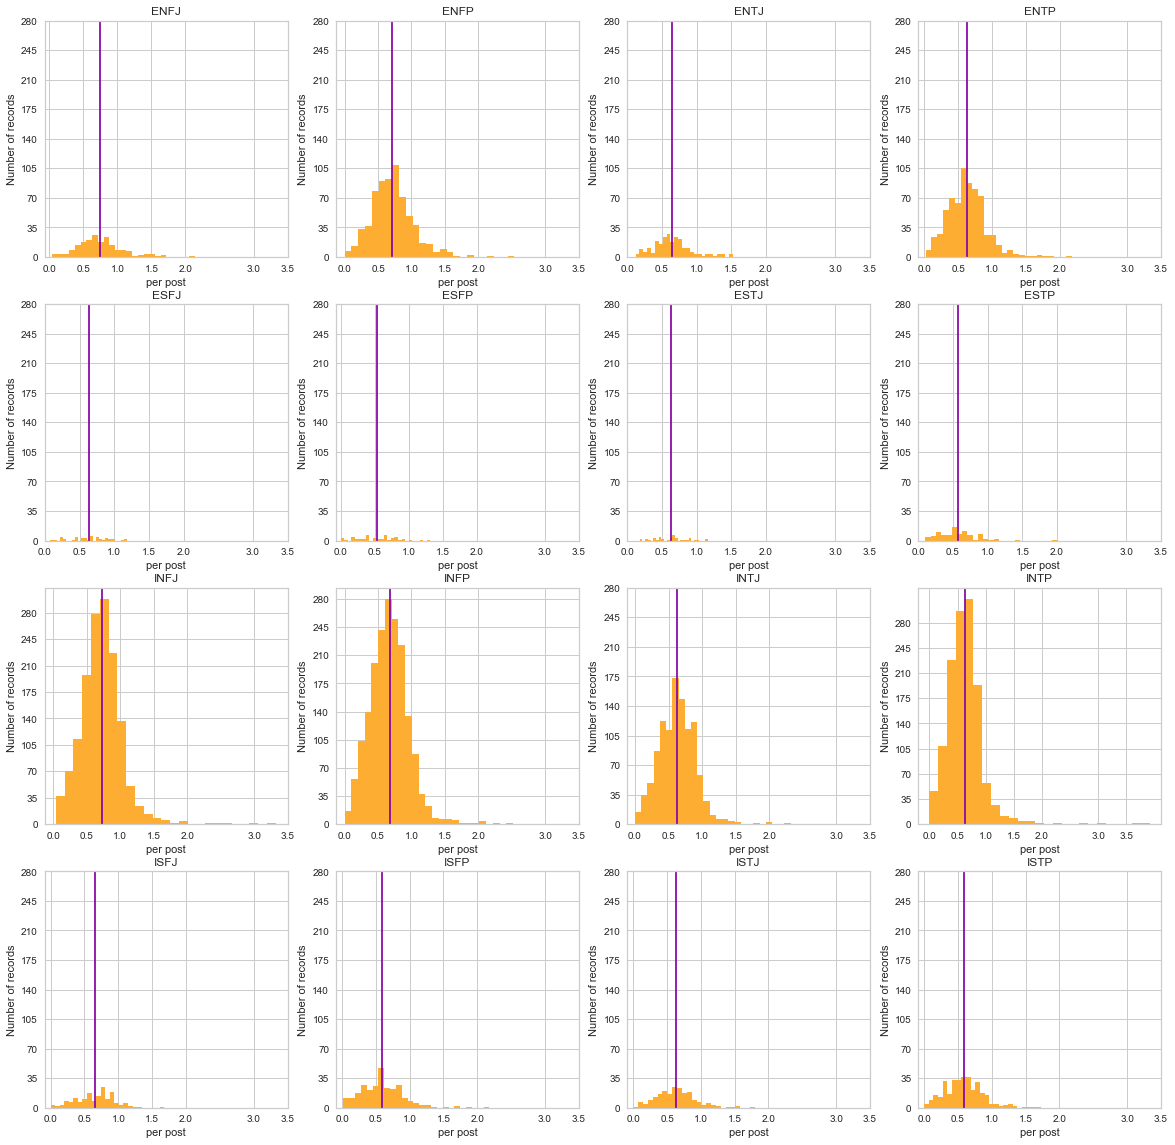

In [75]:
#, ilośc wielokropków

wykres_osobowosci('... per Post',ticks=(0.0,0.5,1.0,1.5,2.0,3.0,3.5),tyks=[0,35,70,105,140,175,210,245,280])


ENFJ: 0.012736842105263164
ENFP: 0.01274074074074069
ENTJ: 0.006147186147186151
ENTP: 0.008671532846715306
ESFJ: 0.007142857142857143
ESFP: 0.007083333333333334
ESTJ: 0.009230769230769232
ESTP: 0.008539325842696632
INFJ: 0.011605442176870663
INFP: 0.01669213973799109
INTJ: 0.009055912007332658
INTP: 0.01277607361963181
ISFJ: 0.011807228915662656
ISFP: 0.020295202952029502
ISTJ: 0.00965853658536586
ISTP: 0.010207715133531164


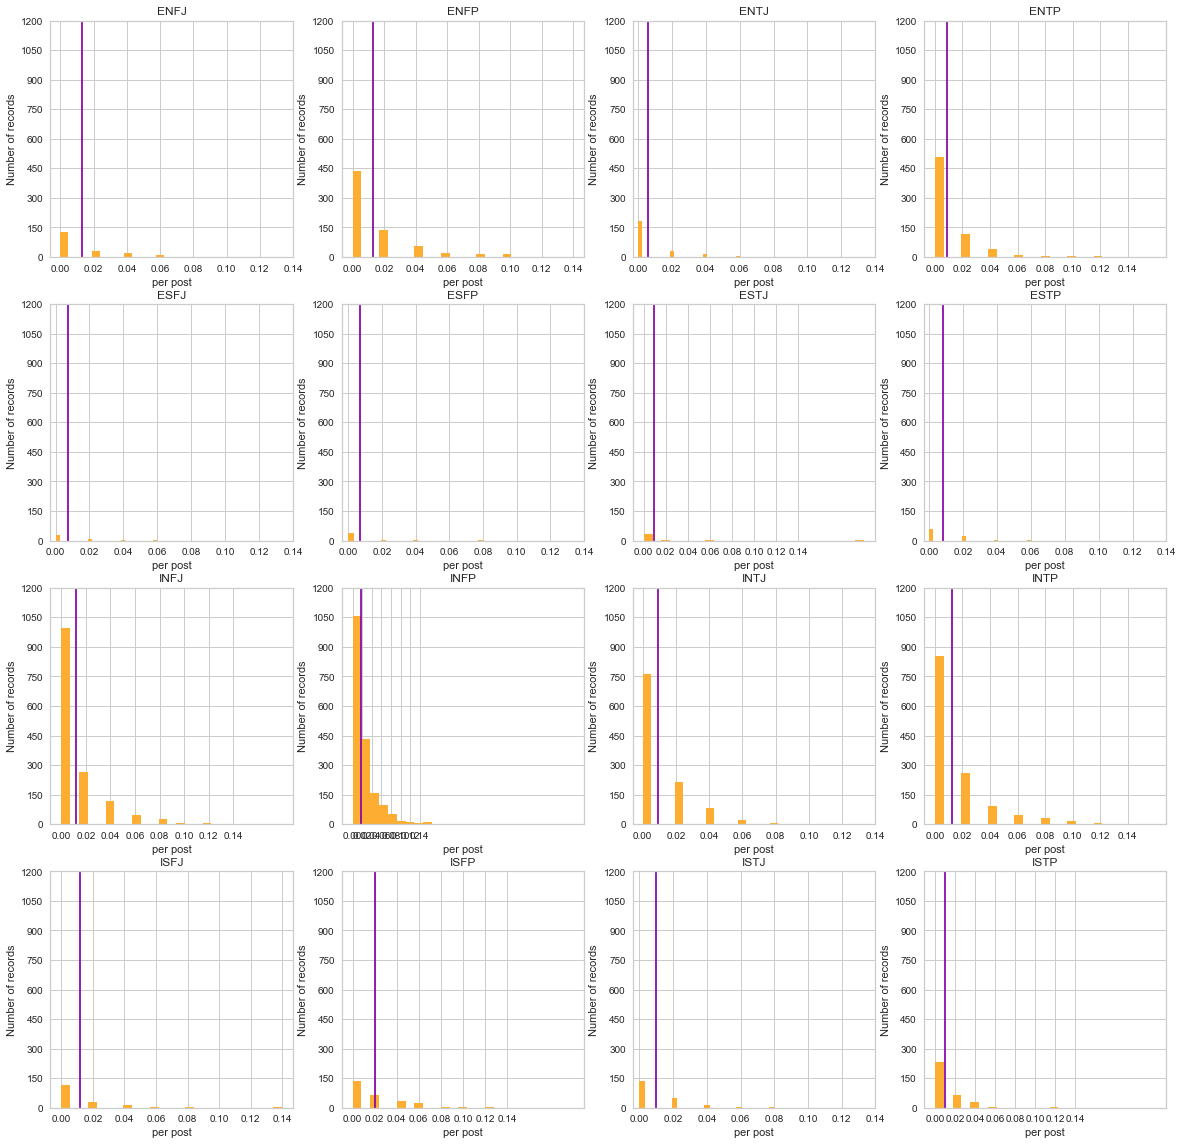

In [76]:
#ilość muzyki

wykres_osobowosci('music per Post',ticks=(0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14),tyks=[0,150,300,450,600,750,900,1050,1200])


ENFJ: 0.011578947368421057
ENFP: 0.01054814814814813
ENTJ: 0.012987012987012993
ENTP: 0.012729927007299227
ESFJ: 0.006666666666666667
ESFP: 0.012500000000000002
ESTJ: 0.01230769230769231
ESTP: 0.01752808988764045
INFJ: 0.012571428571428513
INFP: 0.015534934497816512
INTJ: 0.01470210815765347
INTP: 0.015720858895705434
ISFJ: 0.013975903614457838
ISFP: 0.014612546125461263
ISTJ: 0.013365853658536594
ISTP: 0.014005934718100887


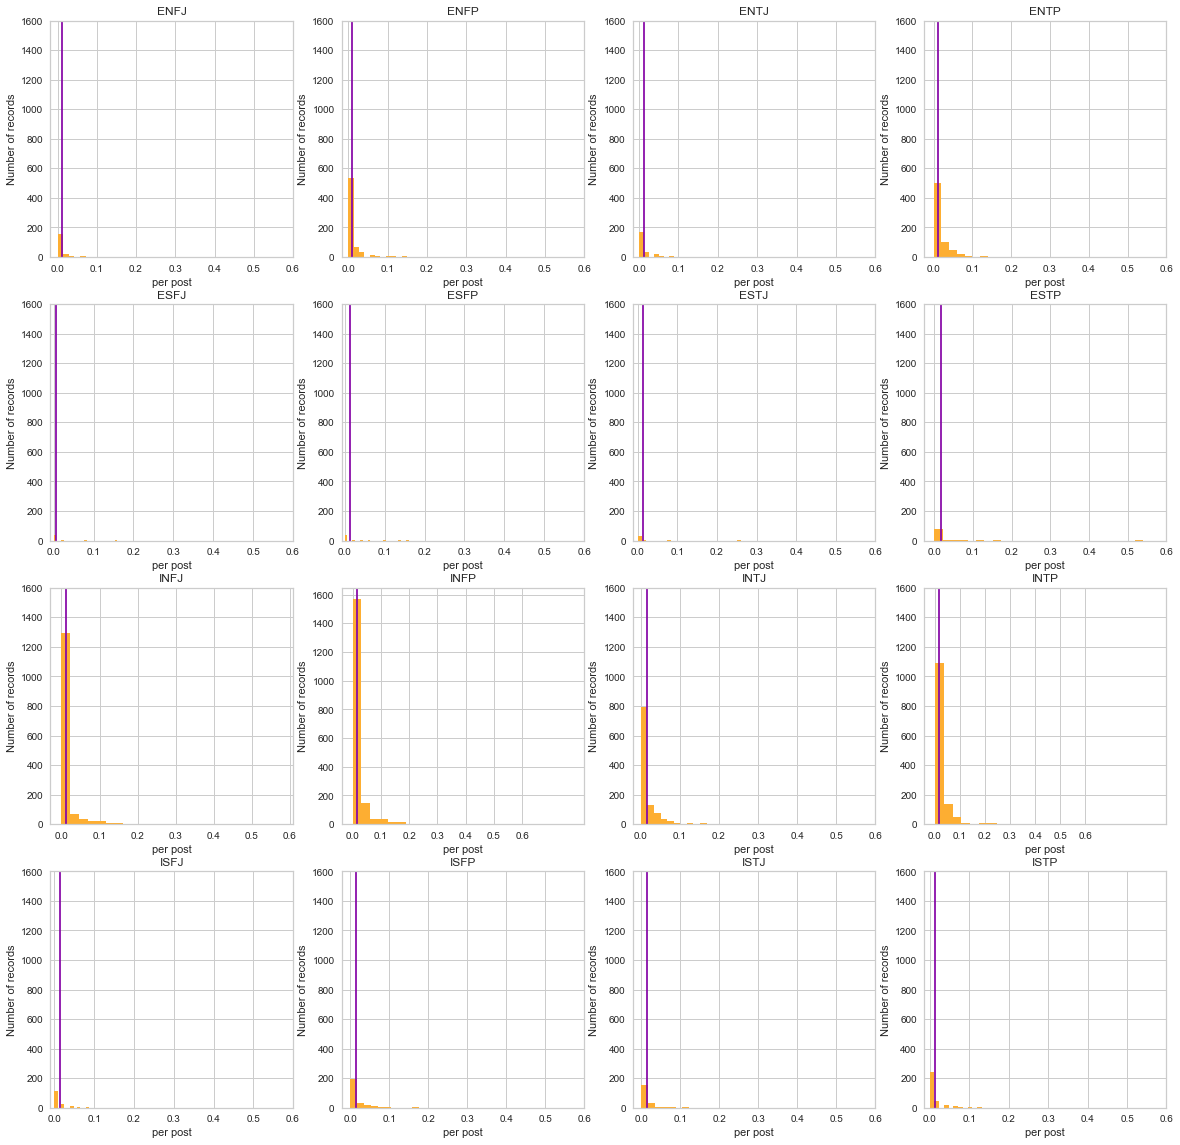

In [77]:
#, ilość jpgów

wykres_osobowosci('jpg per Post',ticks=(0.0,0.1,0.2,0.3,0.4,0.5,0.6),tyks=[0,200,400,600,800,1000,1200,1400,1600])


ENFJ: 1.8402105263157906
ENFP: 1.8632592592592594
ENTJ: 1.6726406926406912
ENTP: 1.629489051094891
ESFJ: 2.0476190476190474
ESFP: 1.5391666666666663
ESTJ: 1.7133333333333336
ESTP: 1.5795505617977532
INFJ: 1.9290884353741473
INFP: 1.8969759825327506
INTJ: 1.6979101741521536
INTP: 1.7457822085889572
ISFJ: 2.0307228915662647
ISFP: 1.8080442804428034
ISTJ: 1.7922926829268289
ISTP: 1.6734718100890196


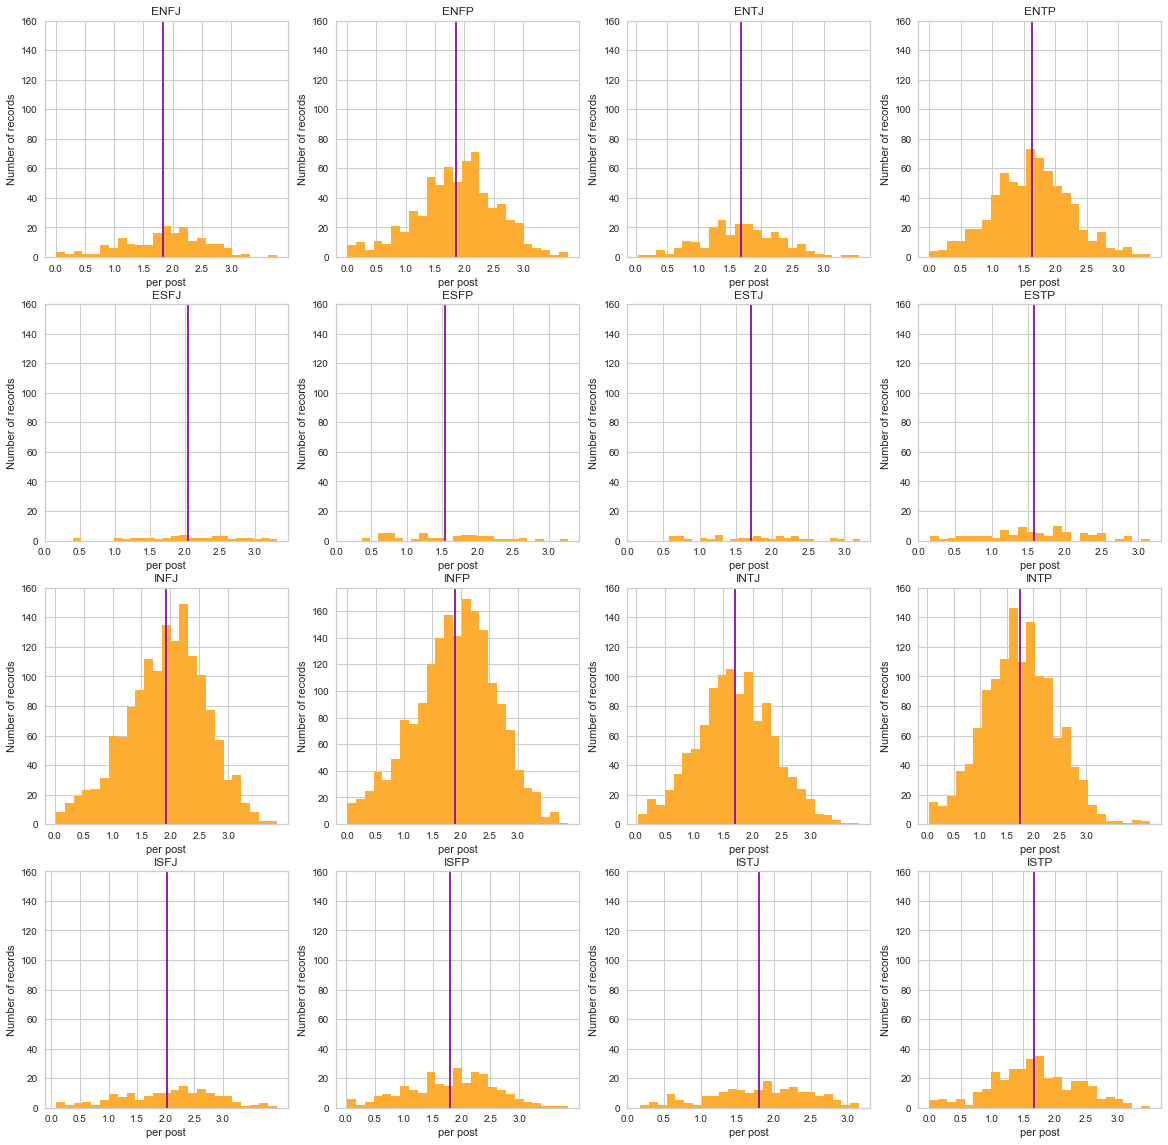

In [78]:
#, ilość użycia 'I'

wykres_osobowosci('I per Post',ticks=(0.0,0.5,1,1.5,2,2.5,3),tyks=[0,20,40,60,80,100,120,140,160])


Widzimy z tego że różnice są widoczne jedynie w Parach cech binarnych

#### Selekcja istotnych Cech

In [79]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)



bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.drop(['type','posts'], axis=1).columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  #print best features

(8675, 6)
(8675,)
            Specs       Score
0  words_per_post  219.272107
5      I per Post   54.593654
1    ... per Post   22.173564
2   http per Post   13.328238
3  music per Post    6.382853
4    jpg per Post    1.907333


Okazuje się że jpg w ogóle nie mają znaczenia a użycie słowa music również nie róznicuje grup

In [80]:
df.drop(['type','posts'], axis=1).corr()

,words_per_post,... per Post,http per Post,music per Post,jpg per Post,I per Post
words_per_post,1.000000,0.694532,-0.420049,0.045314,-0.229499,0.709836
... per Post,0.694532,1.000000,-0.245076,0.026490,-0.120342,0.465793
http per Post,-0.420049,-0.245076,1.000000,0.089092,0.539560,-0.294472
music per Post,0.045314,0.026490,0.089092,1.000000,0.003052,0.064607
jpg per Post,-0.229499,-0.120342,0.539560,0.003052,1.000000,-0.173834
I per Post,0.709836,0.465793,-0.294472,0.064607,-0.173834,1.000000


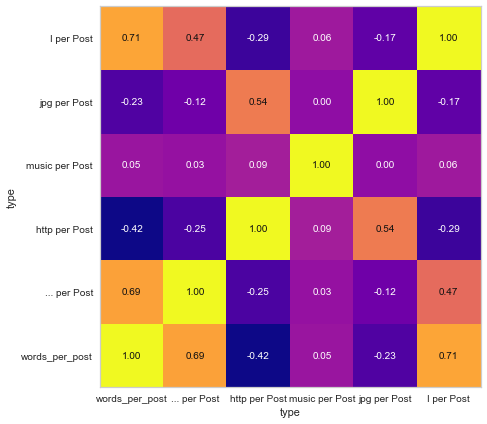

In [81]:
plt.figure(figsize = (7,7))
heatmap(df.drop(['type','posts'], axis=1).corr(), xlabel = 'type', ylabel ='type', xticklabels=['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], yticklabels= ['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], cmap='plasma',
            vmin=None, vmax=None, ax=None, fmt="%0.2f")

Wynika z tego że najbardziej istotne będą cechy: words per post, ... per post oraz I per post

**Dalsza Analiza pokazał jednak znikomy wpływ selekcji cech na wydajność modelu**

### rozpoznanie osobowości MBTI --> pokazanie koniecznośc Resamplingu


In [82]:
XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)


(8675, 6)
(8675,)


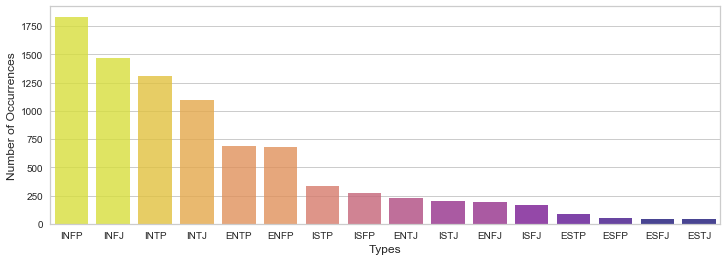

In [ ]:

#Wizualizacja udziału Klas

from matplotlib import cm

cnt_srs = df['type'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [ ]:
#Przykładowy model --> jeden ze zwróconych przez Grid

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

logreg3 = SVC(kernel ='rbf', gamma= 0.1, C=0.1,probability = True)
logreg3.fit(X_train[:,[0,1,5]],y_train)


from sklearn import metrics

print(metrics.accuracy_score(y_test, logreg3.predict(X_test[:,[0,1,5]])))
print(metrics.f1_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='micro'))

Bez Selekcji;

    0.20046082949308755
    0.20046082949308755

In [ ]:
print("R^2: {}".format(metrics.precision_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, logreg3.predict(X_test[:,[0,1,5]])) ))

In [ ]:
#print(metrics.confusion_matrix(y_test, logreg3.predict(X_test[:,[0,1,2,3,5]])))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, logreg3.predict(X_test[:,[0,1,5]]))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

Jak Widać przydzielono tylko i wyłącznie do jednej klasy

### Resampling 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

nm1 = NearMiss(version=1)
sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#X_test_res, y_test_res = sm.fit_sample(X_test, y_test)

#print(y_train_res)
print(y_test.shape)

In [ ]:
#Wizualizacja Zresamplowanych Klas

df_res = pd.DataFrame(X_train_res)
df_res.columns = ['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post']
df_res["type"] = y_train_res


cnt_srs = df_res["type"].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [ ]:
#Feature Selection

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X_train_res,y_train_res)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.drop(['type','posts'], axis=1).columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  #print 10 best features

In [ ]:
plt.figure(figsize = (7,7))
heatmap(df.drop(['type','posts'], axis=1).corr(), xlabel = 'type', ylabel ='type', xticklabels=['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], yticklabels= ['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], cmap='plasma',
            vmin=None, vmax=None, ax=None, fmt="%0.2f")

3 bajważniejsze Cechy nie zmeniły się

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics


XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [ ]:
#Best Clssificator:
from sklearn.ensemble import ExtraTreesClassifier
Classif_res_Type = ExtraTreesClassifier(max_leaf_nodes = 64, n_estimators = 400)
Classif_res_Type.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Type.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Type.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Type.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Type.predict(X_test)) ))

Selekcja Cech:

    R^2: 0.06337332946630916
    recall_score: 0.057190302764957616
    f1_score: 0.03632682063032406
    accuracy_score: 0.038018433179723504

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Type.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

Klasyfikacja Typów osobowości osiąga żałosne rezultaty: Sprawdźmy czy jeśli nie wybierzemy Cech manualnie coś się zmieni!

### Automatyczna Ekstrakcja Cech

Przeprowadzimy Teraz Automatyczną ekstrakcję ważkich cech za pomocą TFiDF

    TFIDF (ang. TF – term frequency, IDF – inverse document frequency) – ważenie częstością termów – odwrotna częstość w 
    dokumentach – jedna z metod obliczania wagi słów w oparciu o liczbę ich wystąpień, należąca do grupy algorytmów 
    obliczających statystyczne wagi termów. 
    Każdy dokument reprezentowany jest przez wektor, składający się z wag słów występujących w tym dokumencie.
    TFIDF informuje o częstości wystąpienia termów uwzględniając jednocześnie odpowiednie wyważenie znaczenia lokalnego termu
    oraz jego znaczenia w kontekście pełnej kolekcji dokumentów.

TFIDF zwróci nam najczęsciej występujące słowa dla poszczególnych grup, ale ważone miejscem ich wystepowania. Algorytm jednak nie zapewnia analziy Syntatkycznej ani Semnatycznej

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

from bs4 import BeautifulSoup
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



In [ ]:

 #Czyścimy zbiór Danych z  niepotrzebnych linków itp i zastępujemy je sowami kluczowymi


def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text
df['clean_posts'] = df['posts'].apply(cleanText)


In [ ]:
XX = df['clean_posts'].values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)


In [ ]:
#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

from sklearn.feature_extraction.text import CountVectorizer

def Most_frequent_words_in_Group(types):
    XXX = df['clean_posts'].loc[df["type"] == types].values
    
    from matplotlib import cm

    cnt_srs = df['type'].value_counts()
    viridis = cm.get_cmap('plasma', 10)
    colors = viridis(np.flip(np.linspace(0, 1, 10)))
    
    TfidVect  = tfidf.fit_transform(XXX)
    svd_model = tsvd
    data_revitalised = svd_model.fit_transform(TfidVect)
    plt.figure(figsize = (10,10))

    visualizer = FreqDistVisualizer(features=tfidf.get_feature_names(), orient='h',title =types, color = colors,n=10)
    visualizer.fit(TfidVect)
    #visualizer.title(types)
    visualizer.show()
    
    
    
Most_frequent_words_in_Group('INFJ')
Most_frequent_words_in_Group('ISTJ')
Most_frequent_words_in_Group('ISFJ')
Most_frequent_words_in_Group('INTJ')
Most_frequent_words_in_Group('ISTP')
Most_frequent_words_in_Group('ISFP')
Most_frequent_words_in_Group('INFP')
Most_frequent_words_in_Group('INTP')
Most_frequent_words_in_Group('ESTP')
Most_frequent_words_in_Group('ESFP')
Most_frequent_words_in_Group('ESTJ')
Most_frequent_words_in_Group('ENFP')
Most_frequent_words_in_Group('ENTP')
Most_frequent_words_in_Group('ESFJ')
Most_frequent_words_in_Group('ENFJ')
Most_frequent_words_in_Group('ENTJ')






Analiza tfiDF wskazuje na podobne częstosci wystepywania tych samych słów  w poszczególnych Typach

In [ ]:
XX = df['clean_posts'].values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(data_revitalised_train, y_train)


In [ ]:
#Best Clssificators:

Classif_res_Automatic_IE = ExtraTreesClassifier(max_leaf_nodes = 128, n_estimators = 1000)
Classif_res_Automatic_IE.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test)) ))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

Jak widać nie zdaje to Egzaminu:

## Poszczególne Cechy --> Klasyfikacja z Resamplingiem!

    Skoro typy osobowości nie wynikaja emergentnie z cech osobowosci, mozemy je analizować niezależnie. Sprawdźmy na ile uda nam sie zrobic klasyfikator poszczególnych Cech.
    
    Oznaczenia:
    
          Introwersja - 0  Ekstrawersja - 1
          Intuition - 0  Sensing - 1
          Thinking - 0  Feeling - 1
          Judging - 0  Perceiving - 1
          
     Czemu tak? By klasy o mniejszym przydziale były klasą pozytywną, a tym samym zmienić postrzeganie Recall i Precision

In [ ]:
map1 = {"I": 0, "E": 1}
map2 = {"N": 0, "S": 1}
map3 = {"T": 0, "F": 1}
map4 = {"J": 0, "P": 1}
df['I-E'] = df['type'].astype(str).str[0]
df['I-E'] = df['I-E'].map(map1)
df['N-S'] = df['type'].astype(str).str[1]
df['N-S'] = df['N-S'].map(map2)
df['T-F'] = df['type'].astype(str).str[2]
df['T-F'] = df['T-F'].map(map3)
df['J-P'] = df['type'].astype(str).str[3]
df['J-P'] = df['J-P'].map(map4)
df.head(10)

In [ ]:
from matplotlib import cm

cnt_srs = df['I-E'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.title('I-E')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

from matplotlib import cm

cnt_srs = df['N-S'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.title('N-S')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

from matplotlib import cm

cnt_srs = df['T-F'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
plt.title('T-F')
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

from matplotlib import cm

cnt_srs = df['J-P'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
plt.title('J-P')
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [ ]:
#Wizualizacja Razem --> pokazanie że średnie są niemalże identyczne ==> słaba rozpoznawalność

def wykres_osobowosci_razem_2(od_czego,do_czego='type'):
    from matplotlib import cm
  
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 12))
    colors2 = colors[[8,10],:]
    typ_osobow = np.unique(df[do_czego])
    plt.figure(figsize = (10,10))
   # cmap = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(typ_osobow)):
        if typ_osobow[i] ==0:
            plt.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[0])
        else:
            plt.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[6])
    
        plt.hist(df[od_czego].loc[df[do_czego]==typ_osobow[i]],bins=25,color=colors2[i])
        plt.xlabel("per post")
        plt.ylabel("Number of records")

        plt.title(od_czego)
        #print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df['type']==typ_osobow[i]])))
    plt.legend(typ_osobow)
    plt.show



wykres_osobowosci_razem_2('words_per_post',do_czego='I-E')
wykres_osobowosci_razem_2('... per Post',do_czego='I-E')
wykres_osobowosci_razem_2('jpg per Post',do_czego='I-E')
wykres_osobowosci_razem_2('music per Post',do_czego='I-E')
wykres_osobowosci_razem_2('http per Post',do_czego='I-E')
wykres_osobowosci_razem_2('I per Post',do_czego='I-E')

In [ ]:
wykres_osobowosci_razem_2('words_per_post',do_czego='N-S')
wykres_osobowosci_razem_2('... per Post',do_czego='N-S')
wykres_osobowosci_razem_2('jpg per Post',do_czego='N-S')
wykres_osobowosci_razem_2('music per Post',do_czego='N-S')
wykres_osobowosci_razem_2('http per Post',do_czego='N-S')
wykres_osobowosci_razem_2('I per Post',do_czego='N-S')

In [ ]:
wykres_osobowosci_razem_2('words_per_post',do_czego='T-F')
wykres_osobowosci_razem_2('... per Post',do_czego='T-F')
wykres_osobowosci_razem_2('jpg per Post',do_czego='T-F')
wykres_osobowosci_razem_2('music per Post',do_czego='T-F')
wykres_osobowosci_razem_2('http per Post',do_czego='T-F')
wykres_osobowosci_razem_2('I per Post',do_czego='T-F')

In [ ]:
wykres_osobowosci_razem_2('words_per_post',do_czego='J-P')
wykres_osobowosci_razem_2('... per Post',do_czego='J-P')
wykres_osobowosci_razem_2('jpg per Post',do_czego='J-P')
wykres_osobowosci_razem_2('music per Post',do_czego='J-P')
wykres_osobowosci_razem_2('http per Post',do_czego='J-P')
wykres_osobowosci_razem_2('I per Post',do_czego='J-P')

In [ ]:
def wykres_osobowosci_rozdzielon(od_czego,do_czego,ticks=(0,5,10,15,20,25,30,35),yticks = [0,100,200,300,400,500,600,700,800]):
    from matplotlib import cm
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 16))
    typ_osobow = np.unique(df[do_czego])
    print(do_czego)
    fig,axes = plt.subplots(1,2,figsize=(8,8))
    for i,ax in zip(range(len(typ_osobow)),axes.ravel()):
        ax.hist(df[od_czego].loc[df[do_czego]==typ_osobow[i]],bins=25,color=colors[12])
        ax.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[4])
        ax.set_xticks(ticks)
        ax.set_yticks(yticks)
        ax.set_xlabel("per post")
        ax.set_ylabel("Number of records")
        ax.title.set_text(typ_osobow[i])
        print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]])))
    plt.show

warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('words_per_post',j)

In [ ]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('http per Post',j,ticks = [0,0.15,0.3,0.45,0.6,0.75,0.9,1.05,1.2,1.35],yticks = (0,500,1000,1500,2000,3000,3500,4000,4500,5000))

In [ ]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('... per Post',j,ticks=(0.0,0.5,1.0,1.5,2.0,2.5,3.0), yticks = [0,200,400,600,800,1000,1200,1400,1600,1800,2000])

In [ ]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('music per Post',j,ticks=(0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35),yticks = [0,400,800,1200,1600,2000,2400,2800,3200,3600,4000])

In [ ]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('jpg per Post',j,ticks=(0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45),yticks = [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000])

In [ ]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('I per Post',j,ticks=(0.0,1,2,3,4,5,6))

Zobaczmy jeszcze jak wygląda ilość słów w poszczególnych grupach

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

def Most_frequent_words_in_Group(types,pyte='type'):
    XXX = df['posts'].loc[df[pyte] == types].values

    from matplotlib import cm

    cnt_srs = df['type'].value_counts()
    viridis = cm.get_cmap('plasma', 10)
    colors = viridis(np.flip(np.linspace(0, 1, 10)))
    
    
    TfidVect  = tfidf.fit_transform(XXX)
    svd_model = tsvd
    data_revitalised = svd_model.fit_transform(TfidVect)
    plt.figure(figsize = (10,10))
    visualizer = FreqDistVisualizer(features=tfidf.get_feature_names(), orient='h',title =types, color = colors,n=10)
    visualizer.fit(TfidVect)
    #visualizer.title(types)
    visualizer.show()
    
    
print('I-E')    
Most_frequent_words_in_Group(0,pyte = 'I-E')
Most_frequent_words_in_Group(1,'I-E')
print('N-S')  
Most_frequent_words_in_Group(0,'N-S')
Most_frequent_words_in_Group(1,'N-S')
print('T-F')  
Most_frequent_words_in_Group(0,'T-F')
Most_frequent_words_in_Group(1,'T-F')
print('J-P')  
Most_frequent_words_in_Group(0,'J-P')
Most_frequent_words_in_Group(1,'J-P')

**PCA - okazało się zbędne** -- Przeprowdzono również PCA dla każdego z modeli, niestety rezultaty okazały się gorsze

### Klasyfikacja I-E 

In [ ]:
#Czyścimy zbiór Danych z  niepotrzebnych linków itp.

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

from bs4 import BeautifulSoup
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text
df['clean_posts'] = df['posts'].apply(cleanText)


In [ ]:
XX = df['clean_posts'].values
yy = df['I-E'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)


from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_train_res_aut, y_train_res_aut = sm.fit_sample(data_revitalised, y_train)


#####  Klasyfikator 1 --> SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

svmIE = SVC(kernel = 'rbf', C = 1, gamma = 100,probability = True)
svmIE.fit(X_train_res_aut,y_train_res_aut)




In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics


array =metrics.confusion_matrix(y_test, svmIE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [ ]:
from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, svmIE.predict(data_revitalised_test)) ))

In [ ]:
y_score = svmIE.decision_function(data_revitalised_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmIE, data_revitalised_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#####  Klasyfikator 2 --> Extra Trees Classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

RNDIE = ExtraTreesClassifier(max_leaf_nodes = 64, n_estimators =1000)
RNDIE.fit(X_train_res_aut,y_train_res_aut)


In [ ]:
from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, RNDIE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [ ]:
from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, RNDIE.predict(data_revitalised_test)) ))

#####  Klasyfikator 3 (Najlepszy) --> Voting Obu

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

voting_clf_IE = VotingClassifier(
    estimators=[('lr', svmIE), ('svc', RNDIE)], voting='soft')
voting_clf_IE.fit(X_train_res_aut, y_train_res_aut)

In [ ]:

from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, voting_clf_IE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [ ]:
print("R^2: {}".format(metrics.precision_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, voting_clf_IE.predict(data_revitalised_test)) ))

In [ ]:
from sklearn import metrics

R2 = []
Precision = []
Recall = []
F1 = []
Accuracy = []

R2.append(metrics.precision_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro'))
Precision.append(metrics.recall_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro'))
Recall.append( metrics.recall_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro'))
F1.append(metrics.f1_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro'))
Accuracy.append(metrics.accuracy_score(y_test, voting_clf_IE.predict(data_revitalised_test)))

In [ ]:
import pandas as pd
d = {'precision_score': Precision, 
     'recall_score': Recall, 
     'f1_score': F1,
     'accuracy_score' : Accuracy,
     'R2_score': R2
    }
df_wyniki = pd.DataFrame(data=d)
df_wyniki.insert(loc=0, column='Method', value=['IE'])
df_wyniki

### Klasyfikacja N-S z Resamplingiem

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


XX = df.drop(['type','posts','I-E','N-S','T-F','J-P','clean_posts'], axis=1).values
yy = df['N-S'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

#####  Klasyfikator 1 --> SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

svmNS2 = SVC(kernel = 'rbf', C =10, gamma = 100,probability = True)
svmNS2.fit(X_train_res,y_train_res)


In [ ]:

from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, svmNS2.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [ ]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, svmNS2.predict(X_test)) ))

In [ ]:
y_score = svmNS2.decision_function(X_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmNS2, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#####  Klasyfikator 2--> Extra Trees Classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

RNDNS = ExtraTreesClassifier(max_leaf_nodes = 64, n_estimators =1000)
RNDNS.fit(X_train_res,y_train_res)


In [ ]:

from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, RNDNS.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [ ]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, RNDNS.predict(X_test)) ))

#####  Klasyfikator 3 (Najlepszy) --> Voting

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

voting_clf = VotingClassifier(
    estimators=[('lr', svmNS2), ('svc', RNDNS)], voting='soft')
voting_clf.fit(X_train_res, y_train_res)



In [ ]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, voting_clf.predict(X_test)) ))

In [ ]:

from sklearn import metrics

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, voting_clf.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

In [ ]:

R2.append(metrics.precision_score(y_test, voting_clf.predict(X_test),average='macro'))
Precision.append(metrics.recall_score(y_test, voting_clf.predict(X_test),average='macro'))
Recall.append( metrics.recall_score(y_test, voting_clf.predict(X_test),average='macro'))
F1.append(metrics.f1_score(y_test, voting_clf.predict(X_test),average='macro'))
Accuracy.append(metrics.accuracy_score(y_test, voting_clf.predict(X_test)))

import pandas as pd
d = {'precision_score': Precision, 
     'recall_score': Recall, 
     'f1_score': F1,
     'accuracy_score' : Accuracy,
     'R2_score': R2
    }
df_wyniki = pd.DataFrame(data=d)
df_wyniki.insert(loc=0, column='Method', value=['IE','NS'])
df_wyniki

### Klasyfikacja T-F z Resamplingiem

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

XX = df.drop(['type','posts','I-E','N-S','T-F','J-P','clean_posts'], axis=1).values
yy = df['T-F'].values

from sklearn.model_selection import train_test_split
X_train,X_test_norm,y_train,y_test_norm=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

#####  Klasyfikator 1 --> Regresja Logistyczna

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

LogRegTF2 = LogisticRegression(penalty = 'l2', C =100)
LogRegTF2.fit(X_train_res,y_train_res)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, LogRegTF2.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [ ]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, LogRegTF2.predict(X_test_norm)) ))

#####  Klasyfikator 2 --> SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

svmTF = SVC(kernel = 'rbf', C =1000, gamma = 0.1,probability = True)
svmTF.fit(X_train_res,y_train_res)



In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

array =metrics.confusion_matrix(y_test_norm, svmTF.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [ ]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, svmTF.predict(X_test_norm)) ))

In [ ]:
y_score = svmTF.decision_function(X_test_norm)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_norm, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmTF, X_test_norm, y_test_norm)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#####  Klasyfikator 3 (najlepszy) --> Voting

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

voting_clf_TF = VotingClassifier(
    estimators=[('lr', svmTF), ('svc', LogRegTF2)], voting='soft')
voting_clf_TF.fit(X_train_res, y_train_res)



In [ ]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, voting_clf_TF.predict(X_test_norm)) ))

In [ ]:

from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, voting_clf_TF.predict(X_test))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

In [ ]:
R2.append(metrics.precision_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro'))
Precision.append(metrics.recall_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro'))
Recall.append( metrics.recall_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro'))
F1.append(metrics.f1_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro'))
Accuracy.append(metrics.accuracy_score(y_test_norm, voting_clf_TF.predict(X_test_norm)))

import pandas as pd
d = {'precision_score': Precision, 
     'recall_score': Recall, 
     'f1_score': F1,
     'accuracy_score' : Accuracy,
     'R2_score': R2
    }
df_wyniki = pd.DataFrame(data=d)
df_wyniki.insert(loc=0, column='Method', value=['IE','NS','TF'])
df_wyniki

### Klasyfikacja J-P z Resamplingiem

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


XX = df.drop(['type','posts','I-E','N-S','T-F','J-P','clean_posts'], axis=1).values
yy = df['J-P'].values

from sklearn.model_selection import train_test_split
X_train,X_test_norm,y_train,y_test_norm=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

#####  Klasyfikator 1 --> Extra Trees Classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

RNDJP = ExtraTreesClassifier(max_leaf_nodes = 128, n_estimators =1000)
RNDJP.fit(X_train_res,y_train_res)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, RNDJP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [ ]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, RNDJP.predict(X_test_norm)) ))

#####  Klasyfikator 2 --> Regresja Logistyczna

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

LogRegJP = LogisticRegression(penalty = 'l2', C =100)
LogRegJP.fit(X_train_res,y_train_res)
print(metrics.accuracy_score(y_test_norm,LogRegJP.predict(X_test_norm)))

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, LogRegJP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [ ]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, LogRegJP.predict(X_test_norm)) ))

#####  Klasyfikator 3 --> SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics        
svmJP = SVC(kernel = 'rbf', C =1, gamma =100,probability = True)
svmJP.fit(X_train_res,y_train_res)

print(metrics.accuracy_score(y_test_norm,svmJP.predict(X_test_norm)))

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, svmJP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [ ]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, svmJP.predict(X_test_norm)) ))

In [ ]:
y_score = svmJP.decision_function(X_test_norm)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_norm, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmJP, X_test_norm, y_test_norm)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#####  Klasyfikator 4 (Najlepszy) --> Voting

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

voting_clf_JP = VotingClassifier(
    estimators=[('lr', svmJP), ('svc', LogRegJP),('rnd', RNDJP)], voting='soft')
voting_clf_JP.fit(X_train_res, y_train_res)



In [ ]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, voting_clf_JP.predict(X_test_norm)) ))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
array =metrics.confusion_matrix(y_test_norm, voting_clf_JP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [ ]:
R2.append(metrics.precision_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro'))
Precision.append(metrics.recall_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro'))
Recall.append( metrics.recall_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro'))
F1.append(metrics.f1_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro'))
Accuracy.append(metrics.accuracy_score(y_test_norm, voting_clf_JP.predict(X_test_norm)))

import pandas as pd
d = {'precision_score': Precision, 
     'recall_score': Recall, 
     'f1_score': F1,
     'accuracy_score' : Accuracy,
     'R2_score': R2
    }
df_wyniki = pd.DataFrame(data=d)
df_wyniki.insert(loc=0, column='Method', value=['IE','NS','TF','JP'])
df_wyniki

In [ ]:
def Wyniki(miara):
    from matplotlib import cm
  
    print( df_wyniki[miara].values)
    cnt_srs = df_wyniki[miara]
    #eee = df_wyniki.Method.value_counts()
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.flip(np.linspace(0, 1, 4)))
    plt.figure(figsize=(12,4))
    sns.barplot(df_wyniki.Method, cnt_srs, alpha=0.8,palette=colors)
    plt.title(miara)
    plt.ylabel('Wartosci', fontsize=12)
    plt.xlabel('Cechy', fontsize=12)
    plt.show()



### Podsumowanie

    nie udało się osiągnąć dobrego stopnia Klasyfikacji dla poszczególnych Typów osobowości MBTI.
    Klasyfikator dla poszczególnych cech osobowości również nie osiagnęly istotnego stopnia poprawności.

In [ ]:
df_wyniki

In [ ]:

Wyniki('R2_score')
Wyniki('accuracy_score')
Wyniki('f1_score')
Wyniki('recall_score')
Wyniki('precision_score')

df_wyniki    
    

    Możliwe jest stworzenie Modelu niemal w każdej z Cech osobowości, który przekroczy poprawność 70% a nawet 90%, lecz przy jednoczesnym poświęceniu Precision i Recall. W takich modelach przewidywany przydział do mniej licznej klasy jest żaden, i to z tego wynika duża poprawność

    Stworzone Modele uwzględniają najlepszy możliwy dla danej Cechy Recall - Precision Tradeoff, przy jednoczesnym            maksymalizowaniu poprawności

    Możliwą przyczyną tego jest niezbalansowany i nie oddający faktycznego występowania poszczególnych typów osobowości 
    zbiór Postów

    Kolejną przyczyną moze być strukturalne podobieństwo ścian tekstu, 
    zmniejszające efektywność TFIDF oraz manualnie wybranych cech w predykcji
    
    Zastosowanie nieefektywnych klasyfikatorów choć mało prawdopodobne też można obwiniać o słabe wyniki. 
    Zbyt mała ilość danych również mogła wpłynąć na efektywność

    Na końcu obwiniana może być sama skala MBTI, która choć szeroko stosowana w praktyce, 
    budzi duże kontrowersje u Psychologów
    Wykazują oni brak korelacji z oryginalnymi Cechami osobowości

    Jak wskazuje David Pittinger (1993), możliwe jest że MBTI w rzeczywistosci nie mierzy cech które 
    mogą być eksponowane w zachowaniu
    
    1. Typy to tylko Stereotypy - nie opisują osobowości informatywnie.
    2. Załozenie wrodzoności szufladkuje ludzi, uniemożliwiając wybor preferencji.
    3. Deskrypcje tylko wydają się psychologicznie akuratne.
    4. Dane z MBTI nie mają rozkłądu bimodalnego co przewidywane byłoby, jeśli osobowości miałyby idealnie pasować.
    5. Nie można polegać na założeniach MBTI szczególnie wrodzoności.
    6. Nie ma dowodu że MBTI może pomóc przewidywać karierę zawodową (w przeciwieństwie do innych miar osobowości jak OCEAN).
    
    
    
